In [1]:
# Importing packages 
import time 
import numpy as np
import os
import pickle
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # To disable trainning in GPU
import tensorflow as tf 
tf.get_logger().setLevel(tf._logging.ERROR)

# Data Loader 
from Data.data_loader import create_train_dataset_memae  # Trainning dataset loader for MemAE model 
from Data.data_loader import create_test_dataset_memae  # Trainning dataset loader for MemAE model 


# Importing the models 
from Models.MemAE.model import AE
from Models.MemAE.model import MemAE

# Importing trainning function 
# from Models.MemAE.train import train_ae
from Models.MemAE.train import train_memae

# Loss function 
# from  Models.MemAE.loss import reconstruct_error
# from  Models.MemAE.loss import MemAELoss

# Visualization functions 
from Utils.visualization import plot_two_images,plot_result
from Utils.plots import plot_loss_evol,plot_metric_evol

2023-07-16 22:31:46.410550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 22:31:47.398757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Tensorflow config 
tf.config.list_physical_devices()
tf.config.threading.set_inter_op_parallelism_threads(6) 
tf.config.threading.set_intra_op_parallelism_threads(6)
tf.config.set_soft_device_placement(False)

2023-07-16 22:31:49.702527: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-07-16 22:31:49.702591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: OSIL
2023-07-16 22:31:49.702598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: OSIL
2023-07-16 22:31:49.702772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.54.3
2023-07-16 22:31:49.702799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.54.3
2023-07-16 22:31:49.702804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.54.3


### Loading data

In [3]:
# Dimensions of data 
H = 256
W = 256
nb_frames = 16

In [4]:
#? Loading trainning dataset for MemAE model 
data_train = create_train_dataset_memae(H,W,nb_frames,load_ped2 = True ,load_ped1=False,shuffle=False,m=154,save=True,save_path='./Data',path_ped2='./Data/UCSDped2',path_ped1='./Data/UCSDped1')
#? Loading the test data 
data_test,data_test_gt,data_test_labels = create_test_dataset_memae(H,W,nb_frames,load_ped2 = True ,load_ped1=False,save=True,save_path='./Data',path_ped2='./Data/UCSDped2',path_ped1='./Data/UCSDped1')



<<<  Loading trainning dataset >>>
path : ./Data/train_(154, 16, 256, 256, 1).npy
Dataset alreardy prepared, loading it
Data loaded , shape (154, 16, 256, 256, 1), size 1232.0 MB 


<<<  Loading testing dataset >>>
path data : ./Data/test_data_(122, 16, 256, 256, 1).npy
path data gt : ./Data/test_data_gt_(122, 16, 256, 256, 1).npy
path data labels: ./Data/test_data_labels_(122, 16, 256, 256, 1).npy
Dataset alreardy prepared, loading it
Data loaded , shape  data (122, 16, 256, 256, 1), gt data (122, 16, 256, 256, 1), labels (122, 16) size 122.02978515625 MB 



## Training the model  

### Model and training parameters 

In [5]:
learning_rate = 0.0002 #0.0001 gave good results 
nb_epochs = 2
mem_dim = 2000
entropy_loss = 0.002 # 0.002 
shrink_thresh = 0.0005 #0.0025  0.001 0.0015 0.0005 0.0004
batch_size = 6

### History params 

In [6]:
#? History params 
history_params = {
        "dir" : "./Training_History/MemAE", # Folder in which save the data  
        "train_params" : {
            "train_data_shape": data_train.shape,
            "test_data_shape" : data_test.shape,
            "learning_rate" : learning_rate, 
            "nb_epochs" : nb_epochs,
            "mem_dim" :mem_dim,
            "entropy_loss" : entropy_loss, 
            "shrink_thresh" :shrink_thresh,
            "batch_size":batch_size
        },
        "nb_epochs_checkpoint" : 1,  # Save each nb_epochs_checkpoint epoch 
    }

In [7]:
#? Deleting older records 
!rm -r "./Training_History"
!mkdir "./Training_History"

/bin/bash: /home/osil/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/osil/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Optimizer 

In [8]:
# Creation of a new optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Loading an old optimizer 
# with open("./Trainning_History/MemAE/Weights/optimizer_epoch_2.pkl", "rb") as file:
#     optimizer_config = pickle.load(file)
#     optimizer =tf.keras.optimizers.Adam().from_config(optimizer_config)


### Model 

In [9]:
memae_model = MemAE((None,nb_frames,H,W,1),nb_items=mem_dim,
                        delta=shrink_thresh)
memae_model.build((None,nb_frames,H,W,1))
memae_model.summary()

(None, 16, 256, 256, 1)
(None, 2, 16, 16, 1)
Model: "MemAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Encoder)           multiple                  2992256   
                                                                 
 Memory (Memory)             multiple                  512000    
                                                                 
 Decoder (Decoder)           multiple                  2990977   
                                                                 
Total params: 6,495,233
Trainable params: 6,492,801
Non-trainable params: 2,432
_________________________________________________________________


2023-07-16 22:32:15.796570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,2,16,16,256]
	 [[{{node Placeholder}}]]


## Training the model 
* To check the memory usage *top -o %MEM*

In [ ]:
train_losses,val_losses,eval_metrics = train_memae(memae_model,data_train,optimizer,
                validation_data=data_test[5:10,:,:,:,:],
                evaluation_metric=None,epochs=nb_epochs,batch_size=batch_size,
                record_history=True,history_params=history_params)


<<<  Trainning   >>>
Shape of data : (154, 16, 256, 256, 1)
Size of a batch : 6   Number of batchs = 25
Number of epochs : 2

Start of epoch 1 


2023-07-16 22:32:22.607483: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 603979776 exceeds 10% of free system memory.
2023-07-16 22:32:23.096721: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 603979776 exceeds 10% of free system memory.
2023-07-16 22:32:23.514211: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 700876800 exceeds 10% of free system memory.
2023-07-16 22:32:27.127290: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 603979776 exceeds 10% of free system memory.
2023-07-16 22:32:27.127578: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 10% of free system memory.


Btach 0/25  loss= 0.23257669806480408
Btach 1/25  loss= 0.22871574759483337
Btach 2/25  loss= 0.2308768779039383
Btach 3/25  loss= 0.22834472358226776
Btach 4/25  loss= 0.2305496782064438
Btach 5/25  loss= 0.2279004007577896
Btach 6/25  loss= 0.2245652824640274
Btach 7/25  loss= 0.22748352587223053


In [24]:
# Saving the weights 
memae_model.save_weights("./Models/memae_model_weights_(256,256).h5")


In [ ]:
# Loading weights 
memae_model.load_weights("./Models/memae_model_weights_(256,256).h5")

### Plotting the results

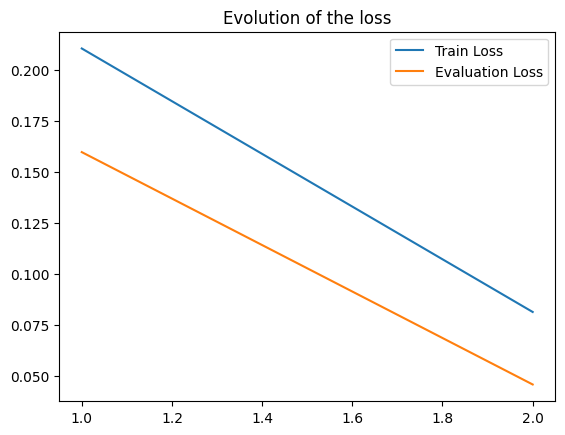

In [25]:
plot_loss_evol(train_losses,val_losses)


## Testing  

In [31]:
# Computing a test image
in_img = data_test[8:9,:,:,:,:]
out_img = memae_model(in_img)[0]
rec_error = (in_img-out_img)**2
anomaly_mask = np.where(rec_error.numpy() > 0.05 , 1, 0)

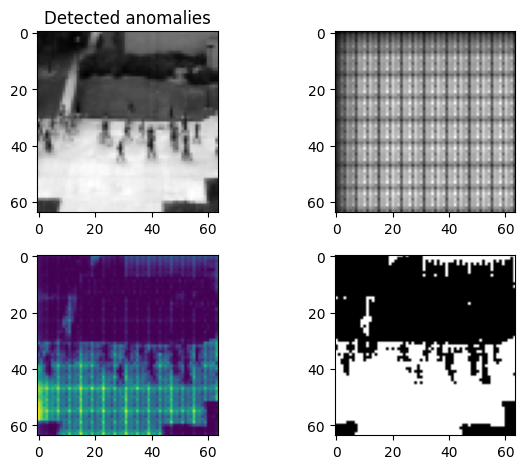

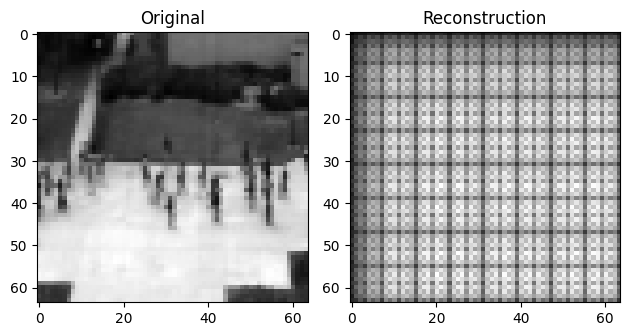

In [32]:
plot_result(in_img[0,-1,:,:,:],out_img[0,-1,:,:,:],rec_error[0,-1,:,:,:],anomaly_mask[0,-1,:,:,:],save=True,filename='/media/osil/Secondary/_Stage_CERIST/Documentation_Paper/images/MemAE/ae_results.png')
plot_two_images(in_img[0,2,:,:,0],out_img[0,2,:,:,0])